<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preparation" data-toc-modified-id="Preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preparation</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Conclusion:" data-toc-modified-id="Conclusion:-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Conclusion:</a></span></li></ul></li></ul></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analysis</a></span><ul class="toc-item"><li><span><a href="#KPSS-&amp;-ADF-tests" data-toc-modified-id="KPSS-&amp;-ADF-tests-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>KPSS &amp; ADF tests</a></span></li><li><span><a href="#Spectrum-(Fourier-transform)" data-toc-modified-id="Spectrum-(Fourier-transform)-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Spectrum (Fourier transform)</a></span></li><li><span><a href="#Analyzing-ACF-&amp;-PACF" data-toc-modified-id="Analyzing-ACF-&amp;-PACF-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Analyzing ACF &amp; PACF</a></span></li><li><span><a href="#Studying-the-form-of-seasonality" data-toc-modified-id="Studying-the-form-of-seasonality-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Studying the form of seasonality</a></span></li><li><span><a href="#Learning-the-shape-of-the-trend" data-toc-modified-id="Learning-the-shape-of-the-trend-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Learning the shape of the trend</a></span></li></ul></li><li><span><a href="#Training" data-toc-modified-id="Training-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training</a></span><ul class="toc-item"><li><span><a href="#Linear-Regression-with-feautures" data-toc-modified-id="Linear-Regression-with-feautures-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Linear Regression with feautures</a></span></li><li><span><a href="#LGBM" data-toc-modified-id="LGBM-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LGBM</a></span></li><li><span><a href="#SARIMA" data-toc-modified-id="SARIMA-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>SARIMA</a></span></li><li><span><a href="#Holt-Winters" data-toc-modified-id="Holt-Winters-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Holt Winters</a></span></li><li><span><a href="#STL-Forecast" data-toc-modified-id="STL-Forecast-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>STL Forecast</a></span></li><li><span><a href="#Facebook-Prophet" data-toc-modified-id="Facebook-Prophet-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Facebook Prophet</a></span></li></ul></li><li><span><a href="#Testing" data-toc-modified-id="Testing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Testing</a></span></li><li><span><a href="#CONCLUSION" data-toc-modified-id="CONCLUSION-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>CONCLUSION</a></span></li><li><span><a href="#Recommendations" data-toc-modified-id="Recommendations-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Recommendations</a></span></li></ul></div>

#  Forecasting taxi orders

The company "An awesome taxi" collected historical data on taxi orders at airports. To attract more drivers during peak load, you need to predict the number of taxi orders for the next hour. Build a model for such a prediction.

The value of the *RMSE* metric in the test sample should be no more than 48.

You need to:

1. Download the data and resample it one hour at a time.
2. Analyze the data.
3. Train different models with different hyperparameters. Make a test sample of 10% of the original data.
4. Check the data on the test sample and draw conclusions.


The data is in the file `taxi.csv'. The number of orders is in the `num_orders` column (from English *number of orders*, "number of orders").

## Preparation

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime as dt
import numpy as np
import seaborn as sns
from numpy.random import RandomState
from pylab import rcParams
# from sklearn.metrics import r2_score
# from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from datetime import datetime, time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_error

from scipy.fft import fft, fftfreq

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm, notebook


from lightgbm import LGBMRegressor

from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.api import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import boxcox
from scipy.special import inv_boxcox

from prophet import Prophet


In [60]:
rcParams['figure.figsize'] = (12, 8)

pd.options.display.float_format = '{:,.3f}'.format
pd.options.display.max_columns = 100
pd.set_option('display.max_rows', 200)
pd.options.mode.chained_assignment = None

plt.rcParams['image.cmap'] = 'Set2'
plt.set_cmap("Set2");

sns.set_style("whitegrid", {'figure.facecolor': '0.97'});
sns.set_palette("Set2");

RANDOM_STATE = 2007

<Figure size 864x576 with 0 Axes>

In [61]:
## FUNCTIONS for studying data (omissions, zeros, correlations, data types)

# let's make a triangular heatmap matrix without diagonal elements
def corr_triag_heatmap(corr, title_str):
    # mask = np.zeros_like(corr)
    # mask[np.triu_indices_from(mask)] = True
    mask = np.triu(np.full(corr.shape, True))
    corr = corr.iloc[1:, :-1]
    mask = pd.DataFrame(mask).iloc[1:, :-1].to_numpy()

    # making a heatmap
    plt.figure(figsize=(corr.shape[0] * 1.2, (corr.shape[0] * 0.6)))
    ax = sns.heatmap(corr, annot=True, cmap="RdBu", mask=mask, vmin=-1, vmax=1)
    ax.set_title(title_str, fontdict={'fontsize':14})
    plt.show()

    
## Function for detecting outliers (using the IQR or 3s method) and removing them
### the column column is analyzed and the distribution of values is looked at and outliers are removed
def calc_bounds_outliers(df, column, mode='iqr', k_lbound=1.5, k_ubound=1.5):    
    t1 = df[column].describe()
    if mode == 'iqr':
        iqr = t1['75%']-t1['25%']
        l_bound = max(t1['25%'] - iqr*k_lbound, t1['min'])
        u_bound = min(t1['75%'] + iqr*k_ubound, t1['max'])
    else:
        l_bound = t1['mean'] - 3*t1['std']
        u_bound = t1['mean'] + 3*t1['std']
    
    return l_bound, u_bound

def show_table_outliers(df, col, mode='iqr', k=3):
    cnt = df.shape[0]
    r = []
    for col in df.select_dtypes(exclude=[object]).columns:
        lbound, ubound = calc_bounds_outliers(df, col, mode=mode, k_lbound=k, k_ubound=k)
        l_out_cnt = len(df[df[col] < lbound])
        u_out_cnt = len(df[df[col] > ubound])
        r.append([col, lbound, ubound, l_out_cnt, u_out_cnt, (l_out_cnt + u_out_cnt)/cnt*100])
    print(f'\nOutliers detection: mode = {mode}, k = {k}')
    display(pd.DataFrame(data=r, columns=['column', 'lbound', 'ubound', 'l_out', 'u_out', 'total_%_out']))


# Let's define a function for studying the dataset, we will apply it to different dataframes
def evaluate_df(df, show_corr_zero_plots = False, show_corr_null_plots=False, show_scatter_matrix=False):
    print('\n------SAMPLE--------')
    display(df.sample(min(5,len(df))))
    print('\n------DTYPES--------')
    print(df.dtypes)

    # count of NaN
    print('\n\n------NaN & zero--------')
    na = pd.DataFrame(index=df.columns
                      , data={
                          'NA':df.isna().sum().values
                          , 'filled': df.notna().sum().values
                          , 'zero':df.isin([0,'0']).sum()
                      }
                     )
    na['%na'] = na['NA']/len(df)*100
    print(na.replace(0,'-'))
    

    display('Numeric columns', df.describe(include=[np.number]).transpose())
    

In [62]:
def RMSE(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

def make_features(data, index_feautures, lags, rolling_mean_size):
    enhanced_data = data.copy()
    if 'Y' in index_feautures:
        enhanced_data['year'] = enhanced_data.index.year
    if 'M' in index_feautures:
        enhanced_data['month'] = enhanced_data.index.month
    if 'D' in index_feautures:
        enhanced_data['day'] = enhanced_data.index.day
    if 'H' in index_feautures:
        enhanced_data['hour'] = enhanced_data.index.hour
    if 'WD' in index_feautures:
        enhanced_data['dayofweek'] = enhanced_data.index.dayofweek
    if 'YW' in index_feautures:
        enhanced_data['weekofyear'] = enhanced_data.index.weekofyear
    
    if type(enhanced_data) == pd.Series:
        enhanced_data = enhanced_data.to_frame()

    data_column = enhanced_data[enhanced_data.columns[0]]
    
    for lag in lags:
        enhanced_data['lag_{}'.format(lag)] = data_column.shift(lag)

    enhanced_data['rolling_mean'] = data_column.shift().rolling(rolling_mean_size).mean()
    return enhanced_data

def plot_cum_rmse(t):
    cs = [np.nan]
    for i in range(1,len(t)):
        cs.append(RMSE(t.iloc[:i,0], t.iloc[:i,1]))
    t['rmse_cum'] = cs
    ax = t['rmse_cum'].plot(xlabel='points', ylabel='RMSE')
    ax.set_title('Change RMSE on adding points')
    
    print('RMSE:', RMSE(t[0], t[1]))
    print('MAE:', mean_absolute_error(t[0],t[1]))
    print('MeanError:', np.mean(t[0]-t[1]))
    plt.show()

In [63]:
# Series Stationarity test (ADF and KPSS)
def test_stationarity(ts):
    statistic, p_value, n_lags, nobs, critical_values, icbest = adfuller(ts, maxlag=None, regression='ct', autolag='AIC', store=False, regresults=False)

    print(f'ADF\n----------------------\nStatistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    if p_value <0.05:
        print('Result:\n\tH0 rejected (H0: The data is not stationary).\n\tH1 accepted: The data is stationary around a trend\n-----------------------\n')
    else:
        print('Result:\n\tH0 could not be rejected (H0: The data is not stationary).\n-----------------------\n')



    statistic, p_value, n_lags, critical_values = kpss(ts, regression='ct', nlags='legacy', store=False)
    print(f'KPSS\n----------------------\nStatistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    # print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary\n-----------------------\n')
    if p_value <0.05:
        print('Result:\n\tH0 rejected (H0: The data is stationary around a trend).\n\tH1 accepted: The data is not stationary\n-----------------------\n')
    else:
        print('Result:\n\tH0 could not be rejected (H0: The data is stationary around a trend).\n-----------------------\n')

# make FastFurierTransform & evaluate main periods
def fft_periods(sgnl):
    # series length
    N = len(sgnl)

    # period
    #(you can enter T=1.0/24.0, but it will be a little less convenient)
    T = 1.0

    # fast 1D Fourier transform
    yf = fft(sgnl)
    xf = fftfreq(N, T)[:N//2]

    # power factor
    power = 2.0/N *np.abs(yf[0:N//2])

    # Spectrum plot
    plt.plot(xf[1:], power[1:])
    # plt.grid()
    plt.show()

    # Let's assemble a frame with periods and power coefficients
    t = pd.DataFrame(data={
        'period': 1/xf[1:],
        'power': power[1:]
    })

    # np.set_printoptions(formatter={'float_kind':'{:f}'.format})

    # Select TOP n and build a histogram (barh)
    n=20
    tN = t[t['period']<N//2].sort_values(by='power').tail(n).sort_values(by='period')
    tN.plot.barh(y='power', x='period', ylabel='period', title=f'TOP{n} periods')
    plt.show()

# Plotting ACF and PACF
def tsplot(y, lags=None, figsize=(18, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

#         print("The Dickey-Fuller criterion: p=%f" % adfuller(y)[1])

        plt.tight_layout()
    return 

In [64]:
data = pd.read_csv('../../datasets/taxi.csv', sep=',', index_col=[0], parse_dates=[0])

In [65]:
# check for the monotony of the date index and sort if necessary
if ~data.index.is_monotonic:
    data.sort_index(inplace=True)
    
# resampling for 1 hour (24 points per day)
data = data.resample('1H').sum()
dataD = data.resample('1D').sum()

In [66]:
# Let's study the data
evaluate_df(data, False, False, False)


------SAMPLE--------


,num_orders
datetime,
2018-08-06 16:00:00,204
2018-08-20 16:00:00,172
2018-08-22 21:00:00,137
2018-08-09 21:00:00,144
2018-04-14 02:00:00,52



------DTYPES--------
num_orders    int64
dtype: object


------NaN & zero--------
           NA  filled  zero %na
num_orders  -    4416     1   -


'Числовые поля'

,count,mean,std,min,25%,50%,75%,max
num_orders,"4,416.000",84.423,45.024,0.000,54.000,78.000,107.000,462.000


There is one zero in the data. This will need to be taken into account when choosing a model

<AxesSubplot:xlabel='datetime'>

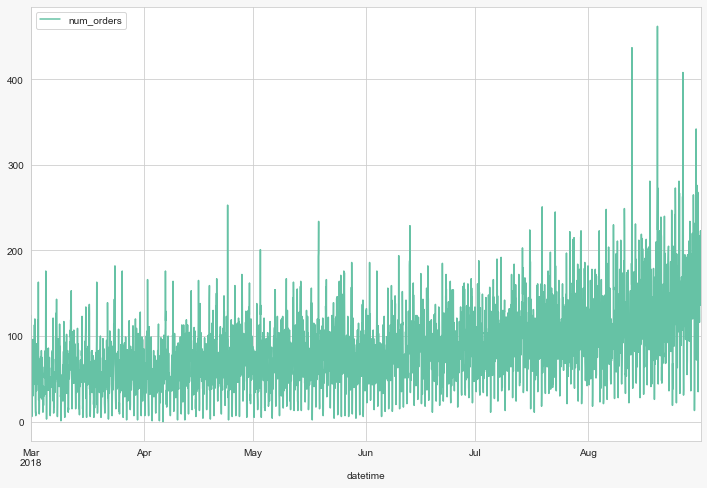

In [67]:
# plot a time series graph
data.plot()

Let's check that there are no gaps in the data (missed hours). To do this, let's calculate how many hours there should be between MAX and MIN hours and compare how many records we actually have.

In [68]:
data.index[-1]-data.index[0]

Timedelta('183 days 23:00:00')

In [69]:
# The number of hours in observations that should be
183*24+23+1

4416

In [70]:
# Actual number of hours
len(data)

4416

#### Conclusion:

There are no gaps in the data, there is one zero value. Outliers are visible in the last months of data, this will probably lead to a higher RMSE on the test compared to validation

## Analysis

Let's check the stationarity of the series near the trend with tests

### KPSS & ADF tests
The hypotheses for the ADF (Augmented Dickey-Fuller) test for non stationarity<br>
* H0: The data is not stationary
* H1: The data is stationary around a trend
<br><br>

The hypotheses for the KPSS (Kwiatkowski-Phillips-Schmidt-Shin) test for stationarity<br>
* H0: The data is stationary around a trend
* H1: The data is not stationary


ADF has high risk of error II type (to not reject false H0). ADF often define non stationary series as stationary

In [71]:
test_stationarity(data)

ADF
----------------------
Statistic: -8.32652157237996
p-value: 1.2583924361794197e-11
num lags: 30
Critial Values:
   1% : -3.960836041046122
   5% : -3.4114917019432394
   10% : -3.127639850914672
Result:
	H0 rejected (H0: The data is not stationary).
	H1 accepted: The data is stationary around a trend
-----------------------

KPSS
----------------------
Statistic: 1.1696420622956918
p-value: 0.01
num lags: 31
Critial Values:
   10% : 0.119
   5% : 0.146
   2.5% : 0.176
   1% : 0.216
Result:
	H0 rejected (H0: The data is stationary around a trend).
	H1 accepted: The data is not stationary
-----------------------



It turned out to be something contradictory.

The ADF test said that this is **exactly a stationary** of a series near the trend (the probability of non-stationarity is 1E-11), <br>the KPSS test showed that this is **definitely not a stationary** test (the probability of stationarity is less than 1%, approximately 1E-9)

Well, we consider the series to be non-stationary then.

### Spectrum (Fourier transform)

We use the fast Fourier transform to isolate the main frequencies present in the time series

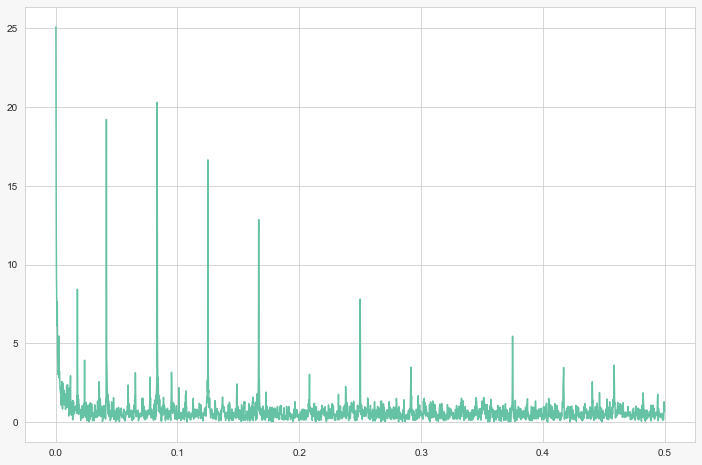

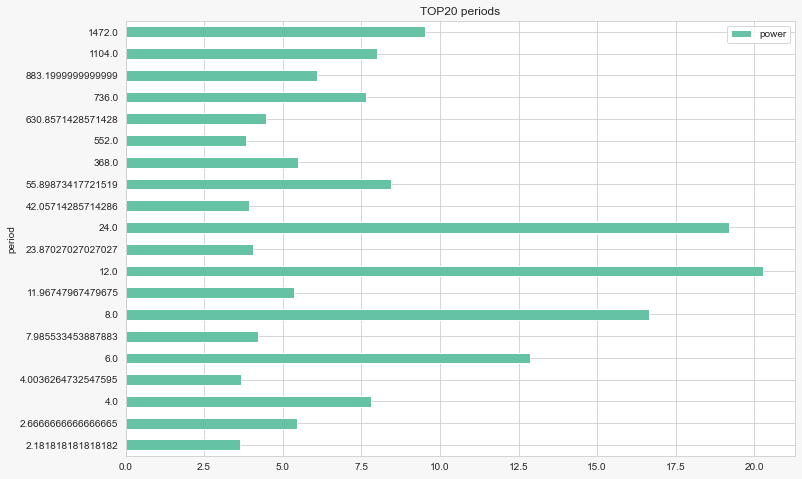

In [72]:
# We allocate a time series as np.array
sgnl = data.iloc[:,0].values
fft_periods(sgnl)

In the spectrum there are harmonics with periods of 4, 6, 8, 12, 24 hours, we take the periodicity of 24 hours (just a day), the remaining periodicities will simply be a seasonality profile
Interestingly, there is no weekly seasonality (168 hours)

### Analyzing ACF & PACF

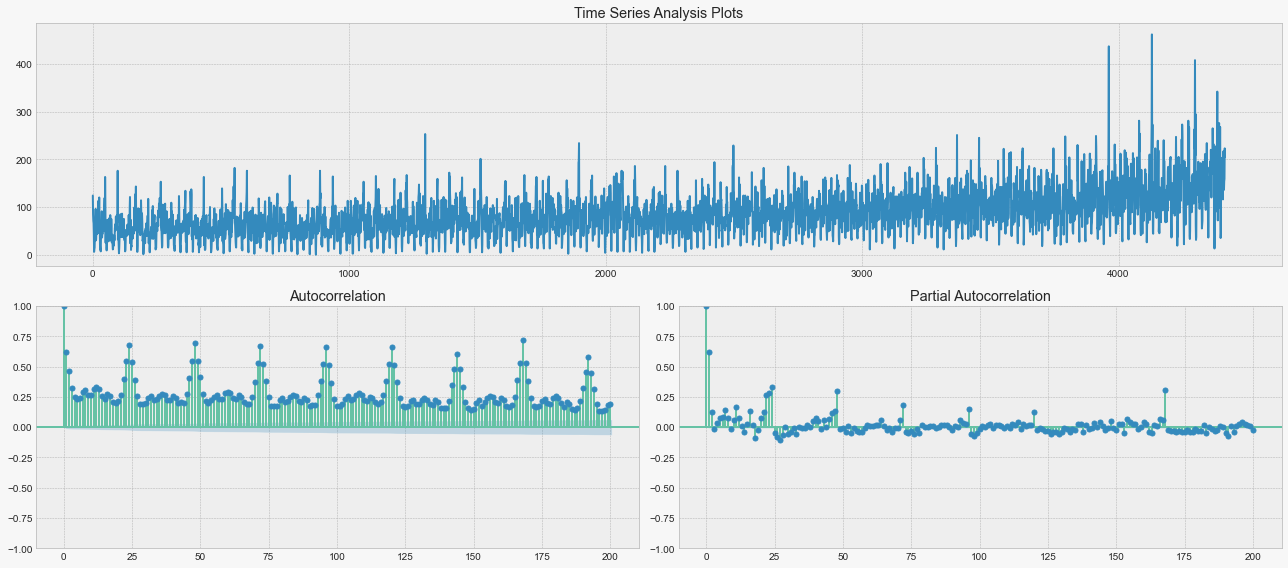

In [73]:
tsplot(sgnl, lags=200)

We see a strong correlation on PACF with a lag of 168 (week)

Let's see what is the reason why FFT did not notice the weekly seasonality.

To do this, we will build a graph of weekly profiles by the hour (the hours are grouped by 2 so that there is less noise and more clearly

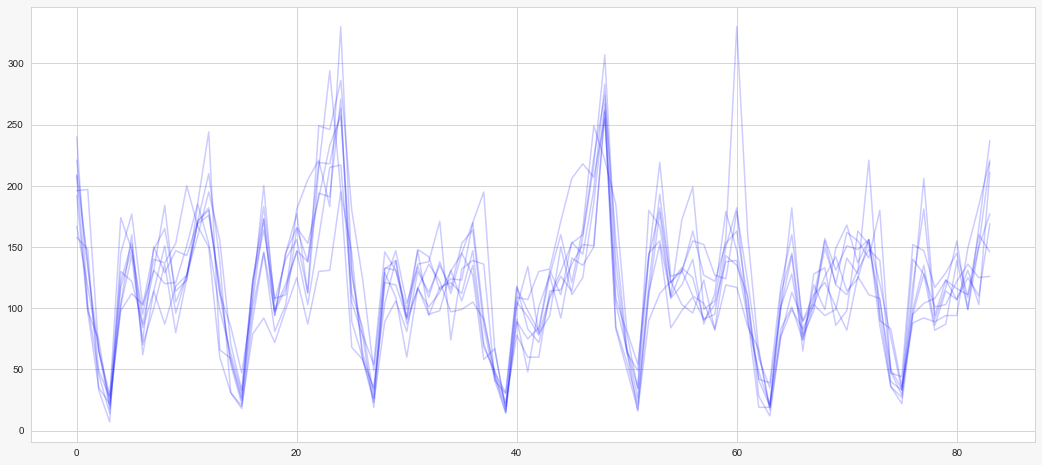

In [74]:
h=2
fig, ax = plt.subplots(figsize=(18,8))
for i in range(8):
    ax.plot(data.resample(str(h)+'H').sum().iloc[int(i*24*7/h):int((i+1)*24*7/h), 0].values, color='b', alpha=0.2)

As you can see, the profile of days depends on the day of the week. But at the same time, the overall level remains about the same. That is why FFT did not find 168h seasonality. FFT is well looking for additive seasonality, example:

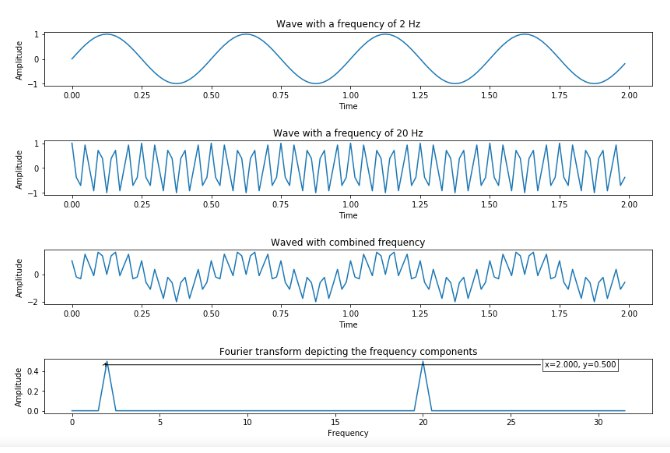

In [75]:
PERIOD = 168

### Studying the form of seasonality

Let's see how the form of seasonality changes

You can use seasonal_decompose from the statsmodels package to determine the type of seasonality
- - If seasonality is additive, then abs residuals will decrease with model='multiplicative' and stable with model='additive'
- If the seasonality is multiplicative, then abs residuals will be stable with model='multiplicative' and grow with model='additive'

In [76]:
from statsmodels.tsa.seasonal import seasonal_decompose

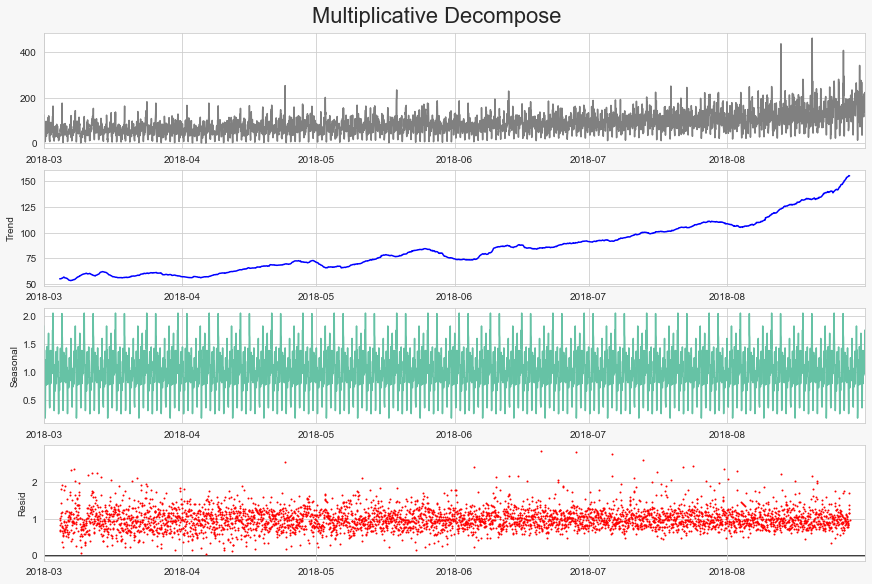



We will see a stable level on this chart If the seasonality is multiplicative


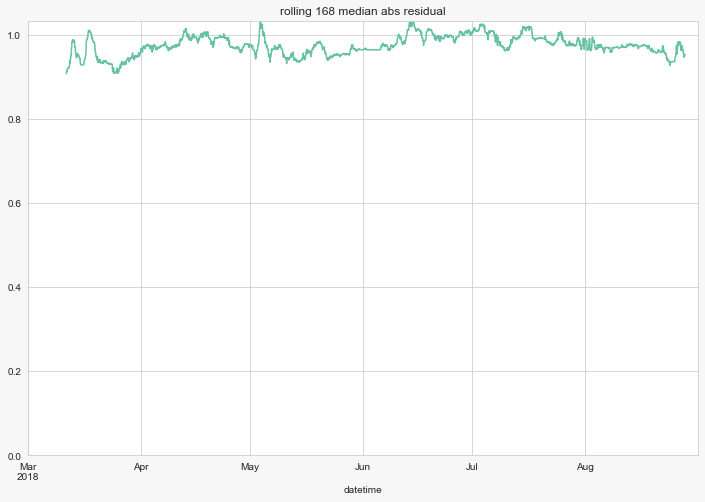

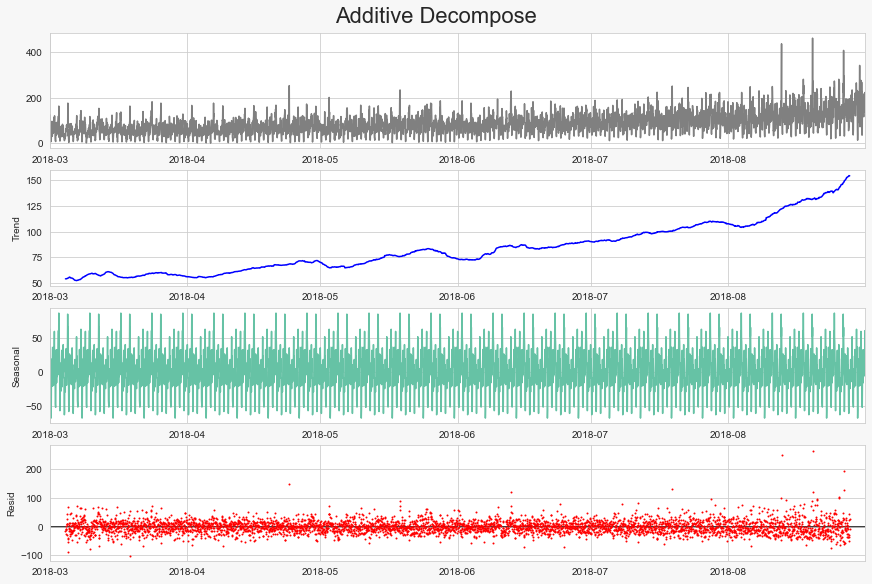



We will see a stable level on this chart If the seasonality is additive


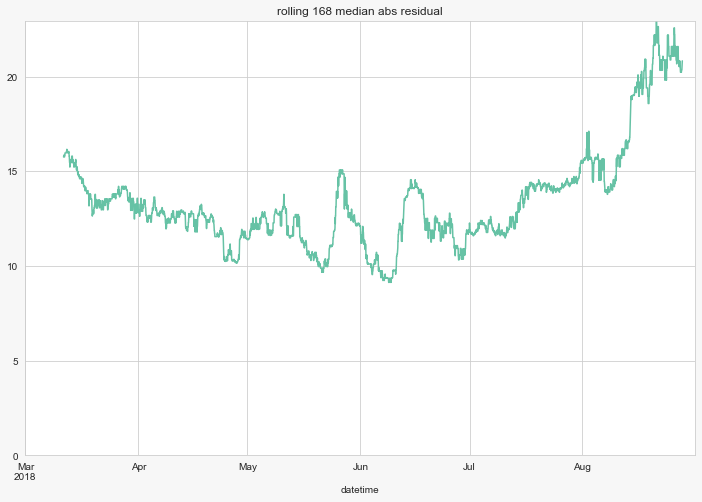

In [85]:
def mad(x):
    return np.median(np.fabs(x))

y = data
# Multiplicative Decomposition 
result_mul = seasonal_decompose(y+1, model='multiplicative',period = 168)

# Additive Decomposition
result_add = seasonal_decompose(y, model='additive',period = 168)

# Plot
fig = result_mul.plot()
fig.set_constrained_layout(constrained=True)
fig.suptitle('Multiplicative Decompose', fontsize=22)
fig.get_axes()[1].get_lines()[0].set_color('b')
fig.get_axes()[0].get_lines()[0].set_color('gray')
res = fig.get_axes()[3].get_lines()[0]
res.set_markersize(2)
res.set_markerfacecolor('r')
res.set_markeredgewidth(0)


plt.show()
# result_mul.resid.rolling(window=PERIOD, min_periods=0).std().plot(legend="rolling "+str(PERIOD)+" std residual")

print('\n\nWe will see a stable level on this chart If the seasonality is multiplicative')
mmde = result_mul.resid.rolling(window=PERIOD, min_periods=0).apply(mad, raw=True)
mmde.plot(title="rolling "+str(PERIOD)+" median abs residual", ylim=(0,max(mmde.dropna())))
plt.show()

fig = result_add.plot()
fig.set_constrained_layout(constrained=True)
fig.suptitle('Additive Decompose', fontsize=22)
fig.get_axes()[1].get_lines()[0].set_color('b')
fig.get_axes()[0].get_lines()[0].set_color('gray')
res = fig.get_axes()[3].get_lines()[0]
res.set_markersize(2)
res.set_markerfacecolor('r')
res.set_markeredgewidth(0)
plt.show()

print('\n\nWe will see a stable level on this chart If the seasonality is additive')
# result_add.resid.rolling(window=PERIOD, min_periods=0).std().plot(title="rolling "+str(PERIOD)+" std residual")
mmde = result_add.resid.rolling(window=PERIOD, min_periods=0).apply(mad, raw=True)
mmde.plot(title="rolling "+str(PERIOD)+" median abs residual", ylim=(0,max(mmde.dropna())))
plt.show()

We see that the seasonality is clearly not additive. Rather closer to the multiplicative


### Learning the shape of the trend

Let's see how the trend changes. Let's look at the daily data

<AxesSubplot:xlabel='datetime'>

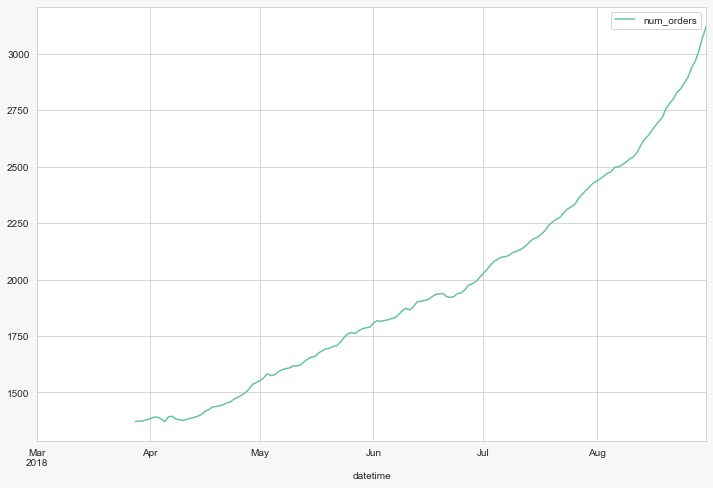

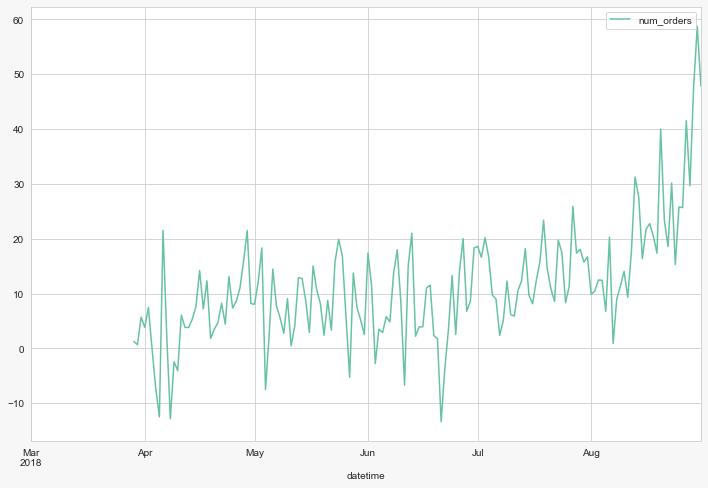

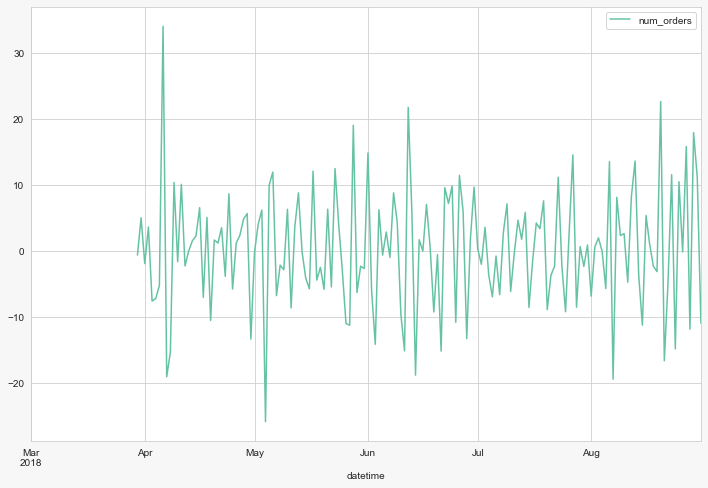

In [86]:
dataD.rolling(28).mean().plot()
dataD.diff(1).rolling(28).mean().plot()
dataD.diff(1).diff(1).rolling(28).mean().plot()

The trend is nonlinear, power-law (two differences brought the trend level to near zero), increasing


## Training

Adding new features

In [87]:
enhanced_data = make_features(
    data, 
    ['WD'], 
    np.concatenate([np.arange(1,25),[168]]), 
    24)
# # Features contain lag =1, i.e. data for 1 hour ago, i.e.
## the model makes a forecast for 1 hour ahead when forecasting,
## using fresh data every time

train, test = train_test_split(enhanced_data.dropna(), shuffle=False, test_size=0.1)
train = train.dropna()

target_name = enhanced_data.columns[0]

X_train = train.drop(columns=[target_name])
y_train = train[target_name]
X_test = test.drop(columns=[target_name])
y_test = test[target_name]
X = enhanced_data.dropna().drop(columns=[target_name])
y = enhanced_data.dropna()[target_name]
N = X.shape[0]
test_start = int(N*0.9)
valid_start = int(N*0.9*0.9)

display('Train&Test shapes', 
        pd.DataFrame(
            data={
                'train': [X_train.shape, len(y_train)], 
                'test': [X_test.shape, len(y_test)] },
            index=['X', 'y']
        )
       )
print(f'valid_start:\t{valid_start}\ntest_start:\t{test_start}\nN:\t\t{N}\nvalid_size =\t{test_start-valid_start}\ntest_size  =\t{N-test_start}')

'Train&Test shapes'

,train,test
X,"(3823, 27)","(425, 27)"
y,3823,425


valid_start:	3440
test_start:	3823
N:		4248
valid_size =	383
test_size  =	425


### Linear Regression with feautures

In [88]:
%%time

model = LinearRegression().fit(X_train, y_train)
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print("rmse train set:",  RMSE(y_train, y_train_pred))
print("rmse test set: ",  RMSE(y_test, y_test_pred))

rmse обучающей выборки: 22.31661968787115
rmse тестовой выборки:  34.720102506461245
CPU times: total: 125 ms
Wall time: 11 ms


In this case, we make fit models on a train sample and then make predictions for each test observation, but at the same time we use features for each observation, including with a lag of 1 (the target value at the last step), i.e. when predicting the next step, we use data for the current step and earlier steps. But then we could restart fit and train the model on more recent data. This should help improve test.

This approach will take longer, but the result should be better. It is especially critical for models like ES, STLForecast, which are actively trained on the latest data.

Let's first select from train the fold of training and validation by the valid_start index

  0%|          | 0/383 [00:00<?, ?it/s]

RMSE: 31.21436087428471
MAE: 21.901976756236287
MeanError: -0.11881469781248796


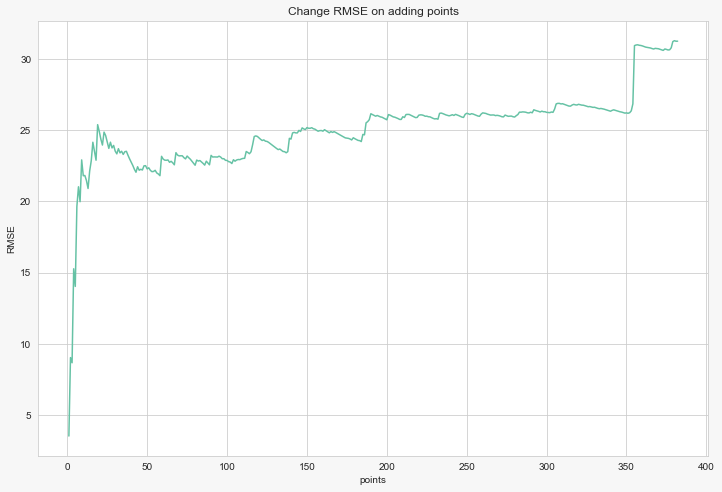

In [89]:
valid_forecast = []
for i in notebook.tqdm(range(valid_start, test_start)):
    # fit model
    model_fit = LinearRegression().fit(X[:i], y[:i])
    
    # make prediction
    prediction = model_fit.predict(X[i:i+1])
    valid_forecast.append([y.iloc[i], prediction[0]])
plot_cum_rmse(pd.DataFrame(valid_forecast))

And we will calculate the metrics on the test to compare

  0%|          | 0/425 [00:00<?, ?it/s]

RMSE: 34.49148566059257
MAE: 25.423601062452995
MeanError: 3.871180748545653


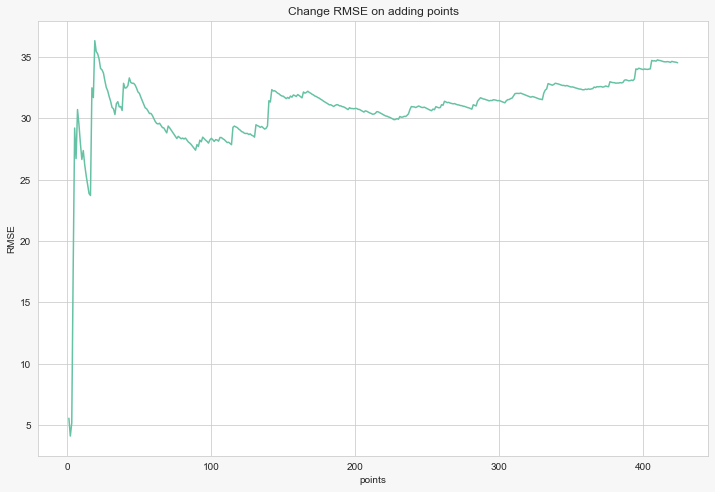

In [90]:
test_forecast = []
for i in notebook.tqdm(range(test_start, N)):
    # fit model
    model_fit = LinearRegression().fit(X[:i], y[:i])
    
    # make prediction
    prediction = model_fit.predict(X[i:i+1])
    test_forecast.append([y.iloc[i], prediction[0]])
plot_cum_rmse(pd.DataFrame(test_forecast))

As you can see, the test has really improved a little, but although the baseline has been beaten, we will try to check other models for validation and only the best one will be launched into the test already.

### LGBM

  0%|          | 0/383 [00:00<?, ?it/s]

RMSE: 30.704158900895248
MAE: 21.058484141686893
MeanError: 1.9664736915187535


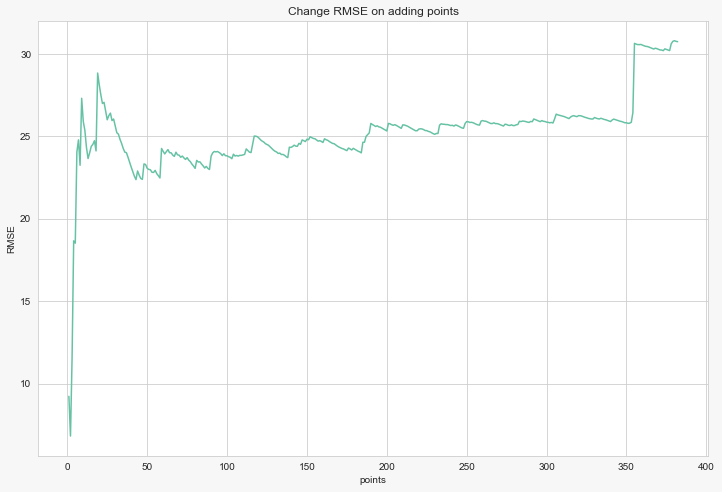

In [91]:


valid_forecast = []
params = {
    'verbose':-1,
    'max_depth': 5,
    'num_iterations': 60,
    'colsample_bytree': 0.85,
    'reg_alpha': 5.5,
    'seed': 38
}

lgb_booster = LGBMRegressor(**params)

for i in notebook.tqdm(range(valid_start, test_start)):
    # fit model
    model_fit = lgb_booster.fit(X[:i], y[:i])
    
    # make prediction
    prediction = model_fit.predict(X[i:i+1])
    valid_forecast.append([y.iloc[i], prediction[0]])
plot_cum_rmse(pd.DataFrame(valid_forecast))

### SARIMA

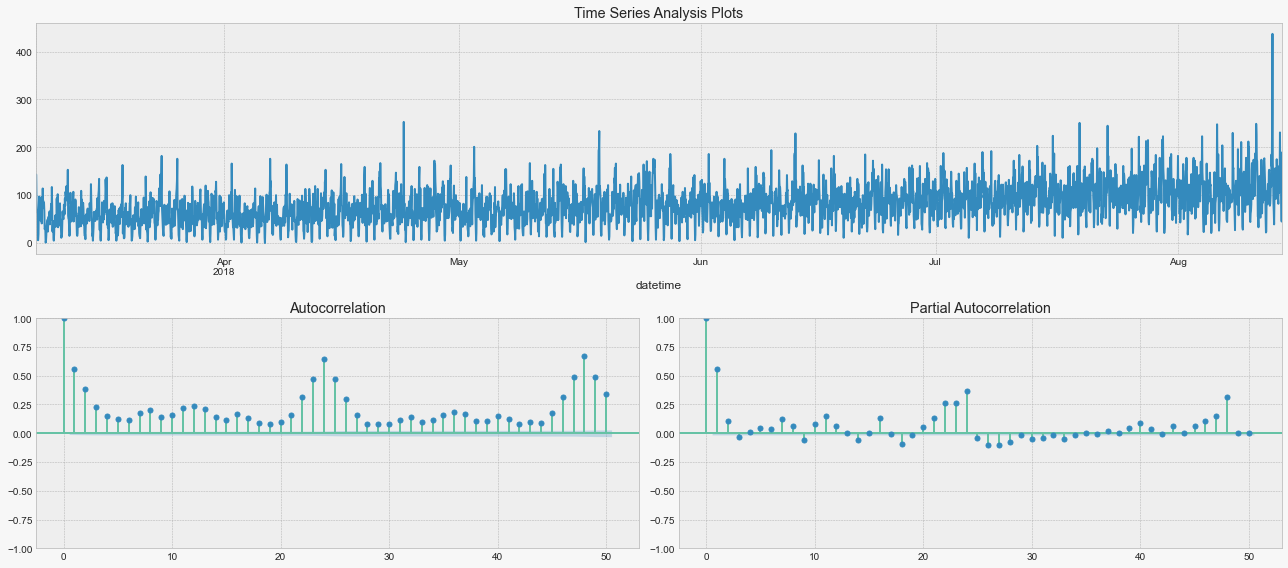

In [92]:
train_series = train.iloc[:,0]
tsplot(train_series, lags=50)

The initial series is not stationary. Let's try to stabilize the variance by the Box-Cox transformation.

Оптимальный параметр преобразования Бокса-Кокса: 0.611539


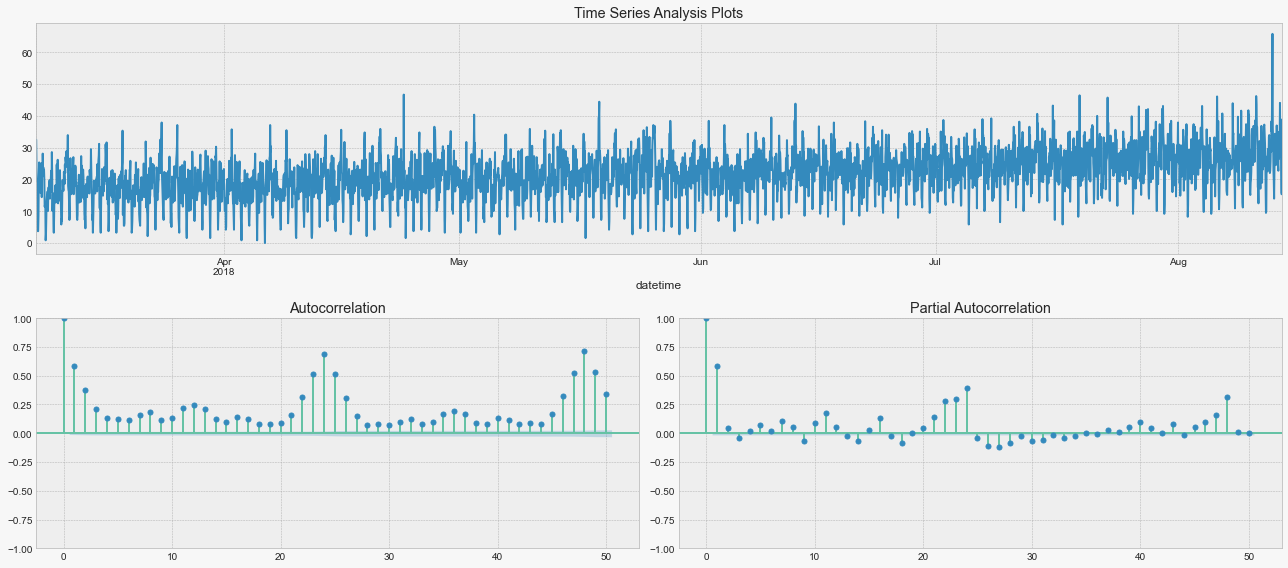

In [93]:
def invboxcox(y,lmbda):
    # inverse BoxCox transformation
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))


df = train_series.to_frame()
df['box'], lmbda = boxcox(df.iloc[:,0]+1) # we add one, since there are zeros in the original series
tsplot(df['box'], lags=50)
print("Optimal Box-Cox transformation parameter: %f" % lmbda)

OK, the variance has been stabilized, but we still need to remove autocorrelation with a seasonality lag of 24.

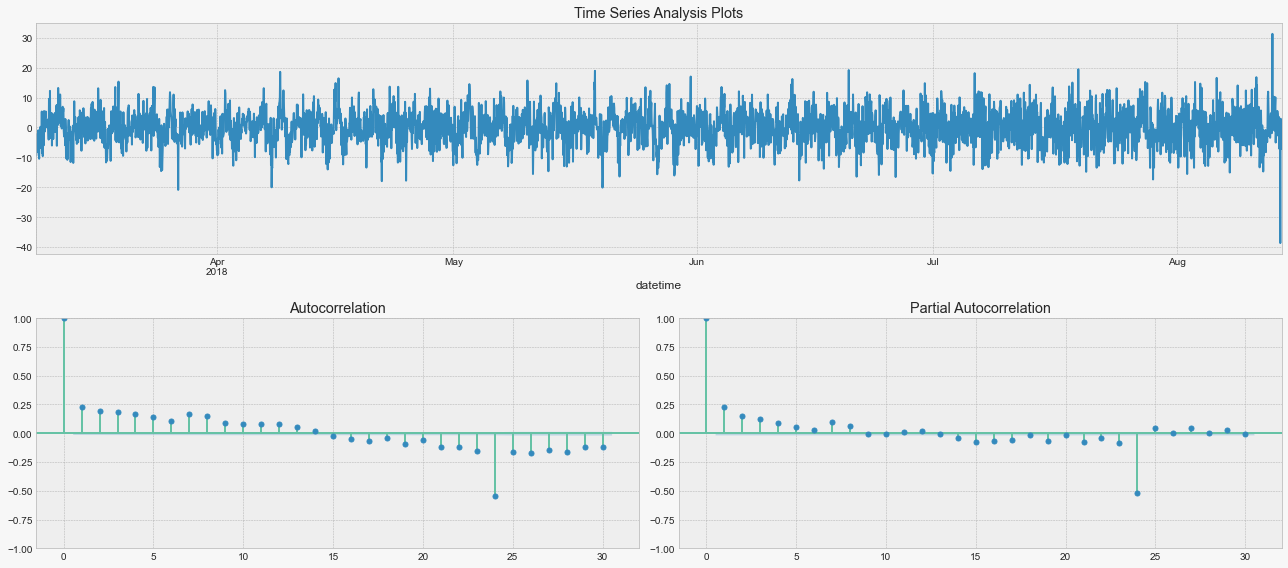

In [94]:
df['box_season'] = df['box'] - df['box'].shift(24)
tsplot(df['box_season'].iloc[24:], lags=30)

OK, that's not bad, you can still work with the seasonal correlation lag 24

Iterating over the hyperparameters of the SARIMA model

In [95]:
ps = range(1, 3) # AR
ds = range(0, 2) # diff
qs = range(0, 3) # MA
Ps = range(1, 3)
Ds = range(1, 2)
Qs = range(0, 3)

from itertools import product

parameters = product(ps, ds, qs, Ps, Ds, Qs)
parameters_list = list(parameters)
print('Number of parameters', len(parameters_list))

Number of parameters 72


In [96]:
# We will leave only those options with no more than 5 parameters
## (otherwise it will take too long for everything to count)

p_list = []
for p in parameters_list:
    if sum(p) <= 5:
        p_list.append(p)
p_list

[(1, 0, 0, 1, 1, 0),
 (1, 0, 0, 1, 1, 1),
 (1, 0, 0, 1, 1, 2),
 (1, 0, 0, 2, 1, 0),
 (1, 0, 0, 2, 1, 1),
 (1, 0, 1, 1, 1, 0),
 (1, 0, 1, 1, 1, 1),
 (1, 0, 1, 2, 1, 0),
 (1, 0, 2, 1, 1, 0),
 (1, 1, 0, 1, 1, 0),
 (1, 1, 0, 1, 1, 1),
 (1, 1, 0, 2, 1, 0),
 (1, 1, 1, 1, 1, 0),
 (2, 0, 0, 1, 1, 0),
 (2, 0, 0, 1, 1, 1),
 (2, 0, 0, 2, 1, 0),
 (2, 0, 1, 1, 1, 0),
 (2, 1, 0, 1, 1, 0)]

In [97]:
%%time
results = []
best_aic = float("inf")

for param in notebook.tqdm(p_list):
    
    #try except is needed because the model is not trained on some parameter sets
    try:
        model = SARIMAX(df['box'], order=(param[0], param[1], param[2]), 
                                        seasonal_order=(param[3], param[4], param[5], 24)).fit(disp=-1)
    # output the parameters on which the model is not trained and move on to the next set
    except ValueError:
        print('wrong parameters:', param)
        continue
    
    aic = model.aic
    print(param, aic)
    
    # saving the best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  0%|          | 0/18 [00:00<?, ?it/s]

(1, 0, 0, 1, 1, 0) 22321.915056311045
(1, 0, 0, 1, 1, 1) 21201.09735587451
(1, 0, 0, 1, 1, 2) 21206.41908838433
(1, 0, 0, 2, 1, 0) 21872.08159463698
(1, 0, 0, 2, 1, 1) 21203.08951561955
(1, 0, 1, 1, 1, 0) 22168.77208720995
(1, 0, 1, 1, 1, 1) 20990.158760318416
(1, 0, 1, 2, 1, 0) 21694.050493657673
(1, 0, 2, 1, 1, 0) 22170.500999079843
(1, 1, 0, 1, 1, 0) 23354.211509133376
(1, 1, 0, 1, 1, 1) 22104.254384145894
(1, 1, 0, 2, 1, 0) 22804.914362799147
(1, 1, 1, 1, 1, 0) 22284.183243078412
(2, 0, 0, 1, 1, 0) 22279.73591278885
(2, 0, 0, 1, 1, 1) 21129.0757950135
(2, 0, 0, 2, 1, 0) 21804.56038829011
(2, 0, 1, 1, 1, 0) 22170.51967219349
(2, 1, 0, 1, 1, 0) 22920.827094898457
            parameters        aic
6   (1, 0, 1, 1, 1, 1) 20,990.159
14  (2, 0, 0, 1, 1, 1) 21,129.076
1   (1, 0, 0, 1, 1, 1) 21,201.097
4   (1, 0, 0, 2, 1, 1) 21,203.090
2   (1, 0, 0, 1, 1, 2) 21,206.419
CPU times: total: 9min 17s
Wall time: 1min 37s


let's look at the CF and ACF residuals

C:\Users\user\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


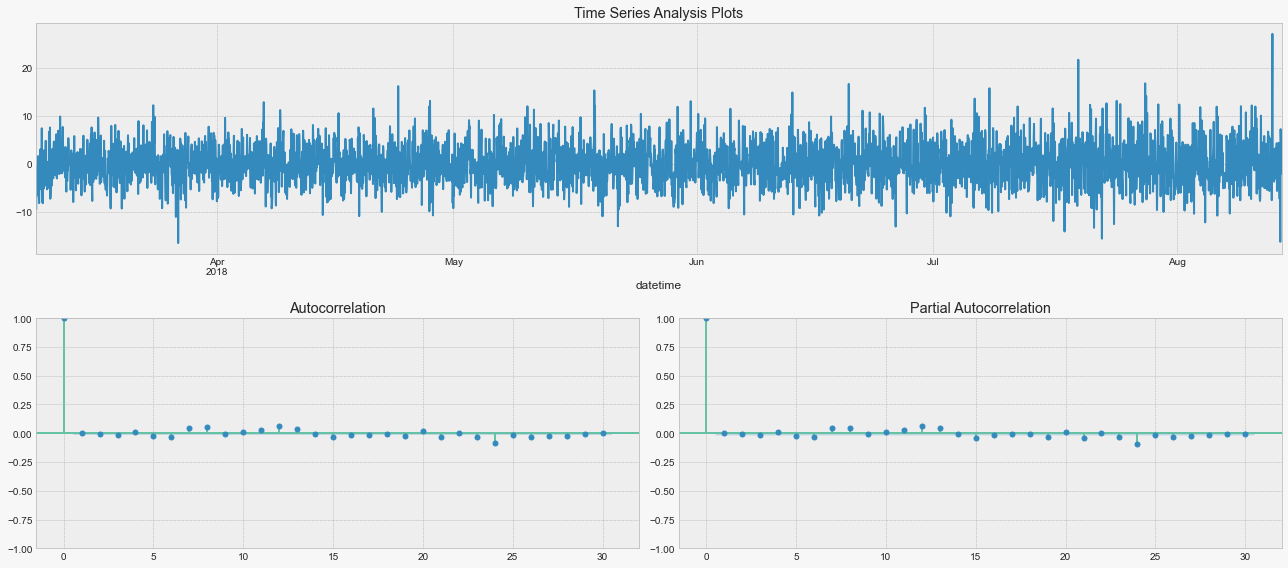

In [101]:
tsplot(best_model.resid[24:], lags=30);

judging by CF and ACF , the remnants of the series have become stationary

In [116]:
%%time
best_model = SARIMAX(df['box'], order=(1, 0, 1), 
                                        seasonal_order=(1, 1, 1, 24)).fit(disp=-1)
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                box   No. Observations:                 3823
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 24)   Log Likelihood              -10490.079
Date:                            Wed, 19 Oct 2022   AIC                          20990.159
Time:                                    17:13:54   BIC                          21021.371
Sample:                                03-08-2018   HQIC                         21001.252
                                     - 08-14-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9232      0.014     67.201      0.000       0.896       0.950
ma.L1         -0.7951      0.021   

Judging by the coefficients of the model, they all have an extremely low probability that the true coefficients are zero. Overall a good model.

We will predict 1 step ahead on the validation fold, each time training the model

  0%|          | 0/383 [00:00<?, ?it/s]

RMSE: 29.936556432660232
MAE: 21.25901428584385
MeanError: 3.13978810454981


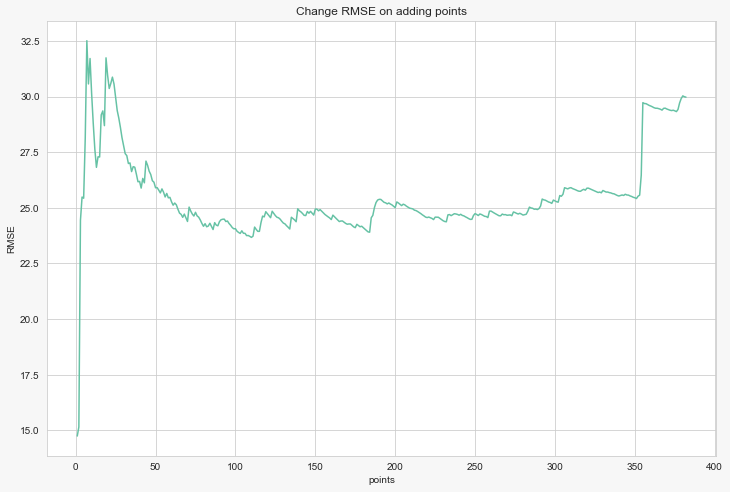

In [117]:
# The launch takes about 5 hours. I blocked the cell for autorun so that each recalculation did not take 5-6 hours
# the code works. To check, you need to unlock False to True
if True:
    valid_forecast = []
    for i in notebook.tqdm(range(valid_start, test_start)):
        ts = y.iloc[:i]
        ts_box, lmbda = boxcox(ts + 1) # we add one, since there are zeros in the original series
        best_model = SARIMAX(ts_box, order=(1, 0, 1), 
                                            seasonal_order=(1, 1, 1, 24)).fit(disp=-1)
        prediction = invboxcox(best_model.predict(start = i, end = i), lmbda)-1
        valid_forecast.append([y.iloc[i], prediction[0]])
        # due to problems with the allocation of RAM, we have to clean the variables
        del best_model
        del ts_box
        del ts
        del prediction
    plot_cum_rmse(pd.DataFrame(valid_forecast))

Saved results of SARIMAX calculations
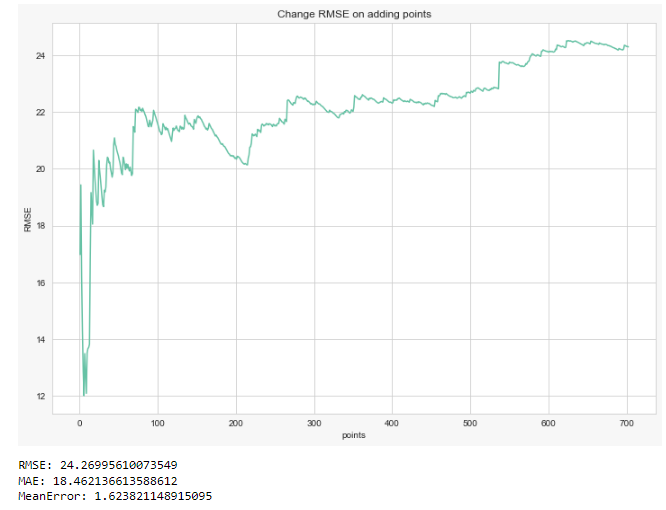

### Holt Winters

Let's try to predict the series 1 step ahead by triple ES (Holt-Winters)

In [104]:
import warnings
warnings.filterwarnings("ignore")

  0%|          | 0/383 [00:00<?, ?it/s]

RMSE: 27.871512281368126
MAE: 18.734784824841128
MeanError: 3.4257897651795446


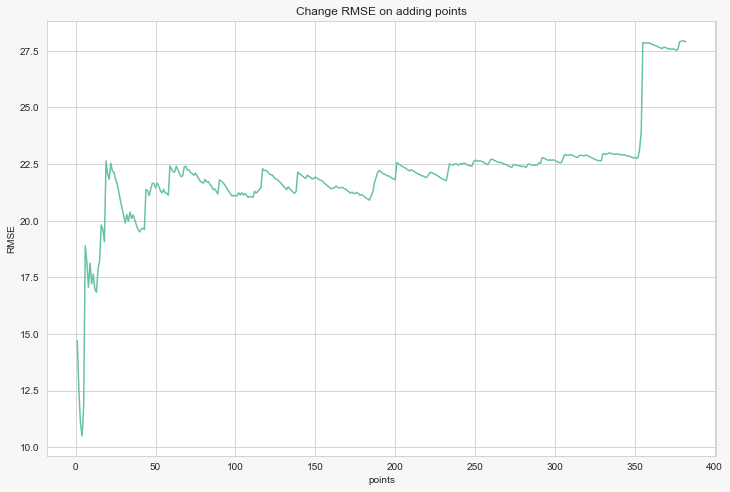

In [105]:
valid_forecast = []
for i in notebook.tqdm(range(valid_start, test_start)):
    # fit model
    model_fit = ExponentialSmoothing(
        endog=y.iloc[:i]+1,
        trend='multiplicative',
        seasonal = 'multiplicative',
        seasonal_periods=PERIOD,
        initialization_method="estimated",
        use_boxcox=False,
    ).fit()
    
    # make prediction
    prediction = model_fit.predict(i, i)-1
    valid_forecast.append([y.iloc[i], prediction.values[0]])
plot_cum_rmse(pd.DataFrame(valid_forecast))

Let's try not a multiplicative model, but an additive one, with a BoxCox transformation

  0%|          | 0/383 [00:00<?, ?it/s]

RMSE: 27.865348182425105
MAE: 18.817094797683463
MeanError: 1.9721115925051822


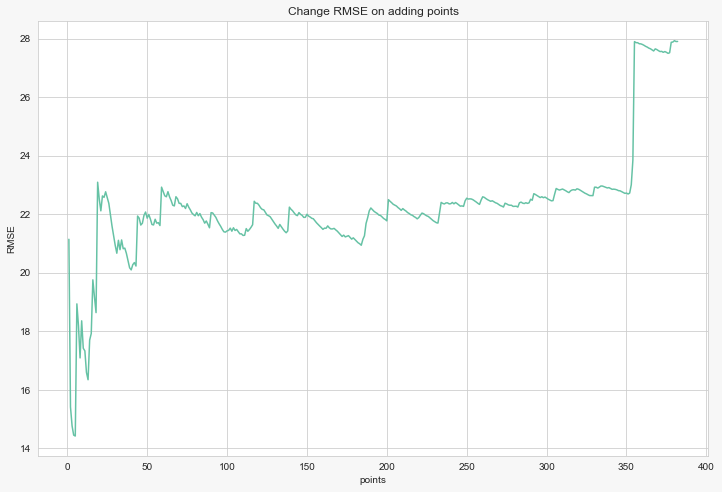

In [106]:
valid_forecast = []
for i in notebook.tqdm(range(valid_start, test_start)):
    # fit model
    model_fit = ExponentialSmoothing(
        endog=y.iloc[:i]+1,
        trend='add',
        seasonal = 'add',
        seasonal_periods=PERIOD,
        initialization_method="estimated",
        use_boxcox=True,
    ).fit()
    
    # make prediction
    prediction = model_fit.predict(i, i)-1
    valid_forecast.append([y.iloc[i], prediction.values[0]])
plot_cum_rmse(pd.DataFrame(valid_forecast))

### STL Forecast

Before predicting STLForecast, let's try to see how strong the smoothing should be so that the trend is smoothed sufficiently strongly and the seasonality does not change very quickly (but at the same time we assume that seasonality can change smoothly)

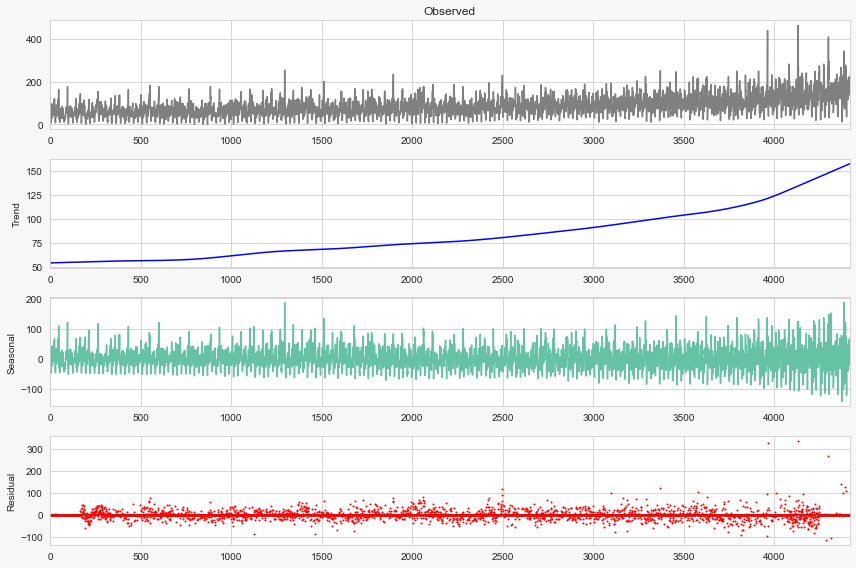

In [107]:
stl_decomposed = STL(
    endog=data.iloc[:,0].values, 
    period=PERIOD, 
    seasonal=5, 
    trend=1+30*24, 
    low_pass=1+1*PERIOD, 
    seasonal_deg=1, 
    trend_deg=1, 
    low_pass_deg=1, 
    robust=True
).fit()

fig = stl_decomposed.plot()
fig.get_axes()[1].get_lines()[0].set_color('b')
fig.get_axes()[0].get_lines()[0].set_color('gray')
res = fig.get_axes()[3].get_lines()[0]
res.set_markersize(2)
res.set_markerfacecolor('r')
res.set_markeredgewidth(0)
plt.show()

Now we are launching two STLForecast models: one on ARIMA, the second on Exponential Smoothing.

As before, we make the forecast 1 step ahead.

  0%|          | 0/383 [00:00<?, ?it/s]

RMSE: 30.755409780758804
MAE: 21.491076692058595
MeanError: 0.13207507130523788


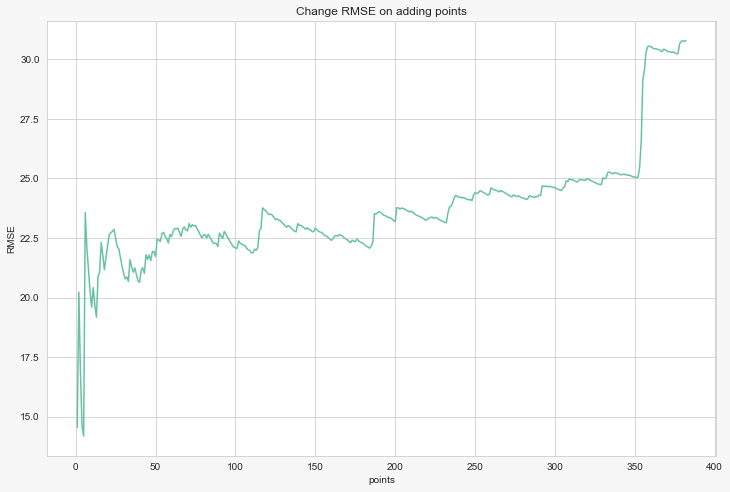

In [108]:
valid_forecast = []
for i in notebook.tqdm(range(valid_start, test_start)):
    # fit model
    model_fit = STLForecast(
        endog=y.iloc[:i],
        model=ARIMA,
        model_kwargs={"order": (2, 1, 0)},
        period=PERIOD, 
        seasonal=PERIOD+1, 
        trend=1+30*24, 
        low_pass=1+1*PERIOD, 
        seasonal_deg=1, 
        trend_deg=1, 
        low_pass_deg=1, 
#         robust=True
    ).fit()
    #(endog, model, *, model_kwargs=None, period=None, seasonal=7, trend=None, low_pass=None, seasonal_deg=1, trend_deg=1, low_pass_deg=1, robust=False, seasonal_jump=1, trend_jump=1, low_pass_jump=1)
    # make prediction
    prediction = model_fit.forecast(1)
    valid_forecast.append([y.iloc[i], prediction.values[0]])
plot_cum_rmse(pd.DataFrame(valid_forecast))



  0%|          | 0/383 [00:00<?, ?it/s]

RMSE: 28.233058266160512
MAE: 19.626576623038165
MeanError: 0.3232405672669076


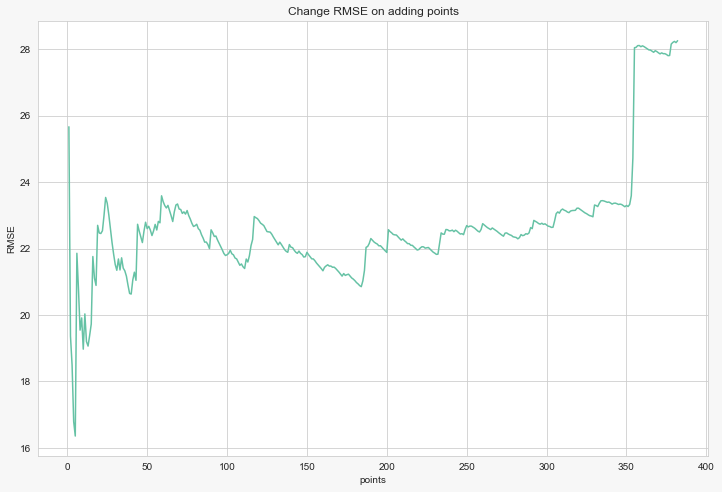

In [109]:
valid_forecast = []
for i in notebook.tqdm(range(valid_start, test_start)):
    # fit model
    model_fit = STLForecast(
        endog=y.iloc[:i], 
        model=ExponentialSmoothing, 
        model_kwargs={"trend": 'add'},
        period=PERIOD, 
        seasonal=PERIOD+1, 
        trend=1+30*24, 
        low_pass=1+1*PERIOD, 
        seasonal_deg=1, 
        trend_deg=1, 
        low_pass_deg=1, 
#         robust=True
    ).fit()

    # make prediction
    prediction = model_fit.forecast(1)
    valid_forecast.append([y.iloc[i], prediction.values[0]])
plot_cum_rmse(pd.DataFrame(valid_forecast))

  0%|          | 0/383 [00:00<?, ?it/s]

RMSE: 28.263100893023903
MAE: 19.467893845949554
MeanError: 1.6950214155625007


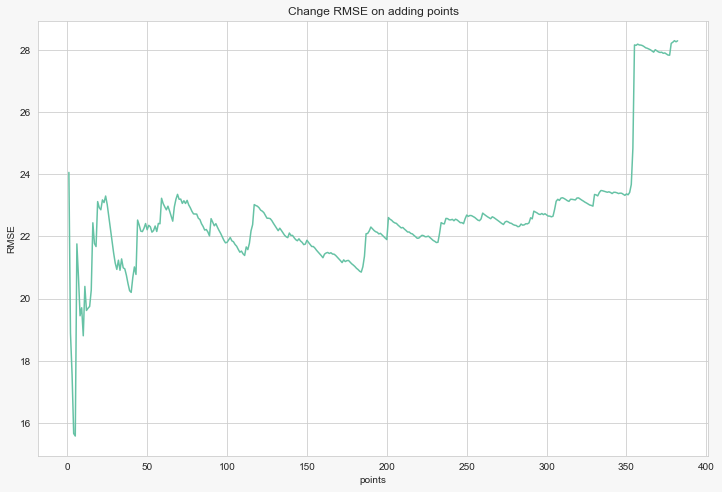

In [110]:
valid_forecast = []
for i in notebook.tqdm(range(valid_start, test_start)):
#     df = train_series.to_frame()
    y_box, lmbda = boxcox(y.iloc[:i]+1) # we add one, since there are zeros in the original series
    # fit model
    model_fit = STLForecast(
        endog=y_box, 
        model=ExponentialSmoothing, 
        model_kwargs={"trend": 'add'},
        period=PERIOD, 
        seasonal=PERIOD+1, 
        trend=1+30*24, 
        low_pass=1+1*PERIOD, 
        seasonal_deg=1, 
        trend_deg=1, 
        low_pass_deg=1, 
#         robust=True
    ).fit()

    # make prediction
    prediction = model_fit.forecast(1)
    valid_forecast.append([y.iloc[i], inv_boxcox(prediction[0], lmbda)-1])
plot_cum_rmse(pd.DataFrame(valid_forecast))

### Facebook Prophet

In [111]:
# pip install prophet

  0%|          | 0/383 [00:00<?, ?it/s]

16:50:17 - cmdstanpy - INFO - Chain [1] start processing
16:50:17 - cmdstanpy - INFO - Chain [1] done processing
16:50:18 - cmdstanpy - INFO - Chain [1] start processing
16:50:18 - cmdstanpy - INFO - Chain [1] done processing
16:50:19 - cmdstanpy - INFO - Chain [1] start processing
16:50:19 - cmdstanpy - INFO - Chain [1] done processing
16:50:20 - cmdstanpy - INFO - Chain [1] start processing
16:50:20 - cmdstanpy - INFO - Chain [1] done processing
16:50:21 - cmdstanpy - INFO - Chain [1] start processing
16:50:21 - cmdstanpy - INFO - Chain [1] done processing
16:50:22 - cmdstanpy - INFO - Chain [1] start processing
16:50:22 - cmdstanpy - INFO - Chain [1] done processing
16:50:23 - cmdstanpy - INFO - Chain [1] start processing
16:50:23 - cmdstanpy - INFO - Chain [1] done processing
16:50:24 - cmdstanpy - INFO - Chain [1] start processing
16:50:24 - cmdstanpy - INFO - Chain [1] done processing
16:50:25 - cmdstanpy - INFO - Chain [1] start processing
16:50:26 - cmdstanpy - INFO - Chain [1]

16:51:31 - cmdstanpy - INFO - Chain [1] done processing
16:51:32 - cmdstanpy - INFO - Chain [1] start processing
16:51:32 - cmdstanpy - INFO - Chain [1] done processing
16:51:33 - cmdstanpy - INFO - Chain [1] start processing
16:51:33 - cmdstanpy - INFO - Chain [1] done processing
16:51:34 - cmdstanpy - INFO - Chain [1] start processing
16:51:34 - cmdstanpy - INFO - Chain [1] done processing
16:51:35 - cmdstanpy - INFO - Chain [1] start processing
16:51:35 - cmdstanpy - INFO - Chain [1] done processing
16:51:36 - cmdstanpy - INFO - Chain [1] start processing
16:51:36 - cmdstanpy - INFO - Chain [1] done processing
16:51:37 - cmdstanpy - INFO - Chain [1] start processing
16:51:37 - cmdstanpy - INFO - Chain [1] done processing
16:51:38 - cmdstanpy - INFO - Chain [1] start processing
16:51:38 - cmdstanpy - INFO - Chain [1] done processing
16:51:39 - cmdstanpy - INFO - Chain [1] start processing
16:51:39 - cmdstanpy - INFO - Chain [1] done processing
16:51:40 - cmdstanpy - INFO - Chain [1] 

16:52:47 - cmdstanpy - INFO - Chain [1] done processing
16:52:48 - cmdstanpy - INFO - Chain [1] start processing
16:52:48 - cmdstanpy - INFO - Chain [1] done processing
16:52:49 - cmdstanpy - INFO - Chain [1] start processing
16:52:49 - cmdstanpy - INFO - Chain [1] done processing
16:52:50 - cmdstanpy - INFO - Chain [1] start processing
16:52:50 - cmdstanpy - INFO - Chain [1] done processing
16:52:51 - cmdstanpy - INFO - Chain [1] start processing
16:52:51 - cmdstanpy - INFO - Chain [1] done processing
16:52:52 - cmdstanpy - INFO - Chain [1] start processing
16:52:52 - cmdstanpy - INFO - Chain [1] done processing
16:52:53 - cmdstanpy - INFO - Chain [1] start processing
16:52:53 - cmdstanpy - INFO - Chain [1] done processing
16:52:54 - cmdstanpy - INFO - Chain [1] start processing
16:52:54 - cmdstanpy - INFO - Chain [1] done processing
16:52:55 - cmdstanpy - INFO - Chain [1] start processing
16:52:55 - cmdstanpy - INFO - Chain [1] done processing
16:52:56 - cmdstanpy - INFO - Chain [1] 

16:54:04 - cmdstanpy - INFO - Chain [1] done processing
16:54:05 - cmdstanpy - INFO - Chain [1] start processing
16:54:05 - cmdstanpy - INFO - Chain [1] done processing
16:54:06 - cmdstanpy - INFO - Chain [1] start processing
16:54:06 - cmdstanpy - INFO - Chain [1] done processing
16:54:07 - cmdstanpy - INFO - Chain [1] start processing
16:54:07 - cmdstanpy - INFO - Chain [1] done processing
16:54:08 - cmdstanpy - INFO - Chain [1] start processing
16:54:08 - cmdstanpy - INFO - Chain [1] done processing
16:54:09 - cmdstanpy - INFO - Chain [1] start processing
16:54:09 - cmdstanpy - INFO - Chain [1] done processing
16:54:10 - cmdstanpy - INFO - Chain [1] start processing
16:54:10 - cmdstanpy - INFO - Chain [1] done processing
16:54:11 - cmdstanpy - INFO - Chain [1] start processing
16:54:12 - cmdstanpy - INFO - Chain [1] done processing
16:54:13 - cmdstanpy - INFO - Chain [1] start processing
16:54:13 - cmdstanpy - INFO - Chain [1] done processing
16:54:14 - cmdstanpy - INFO - Chain [1] 

16:55:22 - cmdstanpy - INFO - Chain [1] done processing
16:55:23 - cmdstanpy - INFO - Chain [1] start processing
16:55:23 - cmdstanpy - INFO - Chain [1] done processing
16:55:24 - cmdstanpy - INFO - Chain [1] start processing
16:55:24 - cmdstanpy - INFO - Chain [1] done processing
16:55:25 - cmdstanpy - INFO - Chain [1] start processing
16:55:25 - cmdstanpy - INFO - Chain [1] done processing
16:55:26 - cmdstanpy - INFO - Chain [1] start processing
16:55:26 - cmdstanpy - INFO - Chain [1] done processing
16:55:27 - cmdstanpy - INFO - Chain [1] start processing
16:55:28 - cmdstanpy - INFO - Chain [1] done processing
16:55:29 - cmdstanpy - INFO - Chain [1] start processing
16:55:29 - cmdstanpy - INFO - Chain [1] done processing
16:55:30 - cmdstanpy - INFO - Chain [1] start processing
16:55:30 - cmdstanpy - INFO - Chain [1] done processing
16:55:31 - cmdstanpy - INFO - Chain [1] start processing
16:55:31 - cmdstanpy - INFO - Chain [1] done processing
16:55:32 - cmdstanpy - INFO - Chain [1] 

16:56:40 - cmdstanpy - INFO - Chain [1] done processing
16:56:41 - cmdstanpy - INFO - Chain [1] start processing
16:56:42 - cmdstanpy - INFO - Chain [1] done processing
16:56:43 - cmdstanpy - INFO - Chain [1] start processing
16:56:43 - cmdstanpy - INFO - Chain [1] done processing
16:56:44 - cmdstanpy - INFO - Chain [1] start processing
16:56:44 - cmdstanpy - INFO - Chain [1] done processing
16:56:45 - cmdstanpy - INFO - Chain [1] start processing
16:56:45 - cmdstanpy - INFO - Chain [1] done processing
16:56:46 - cmdstanpy - INFO - Chain [1] start processing
16:56:46 - cmdstanpy - INFO - Chain [1] done processing
16:56:47 - cmdstanpy - INFO - Chain [1] start processing
16:56:47 - cmdstanpy - INFO - Chain [1] done processing
16:56:48 - cmdstanpy - INFO - Chain [1] start processing
16:56:48 - cmdstanpy - INFO - Chain [1] done processing
16:56:49 - cmdstanpy - INFO - Chain [1] start processing
16:56:49 - cmdstanpy - INFO - Chain [1] done processing
16:56:50 - cmdstanpy - INFO - Chain [1] 

RMSE: 46.35340187009314
MAE: 34.66365106149274
MeanError: 0.9245488352241237


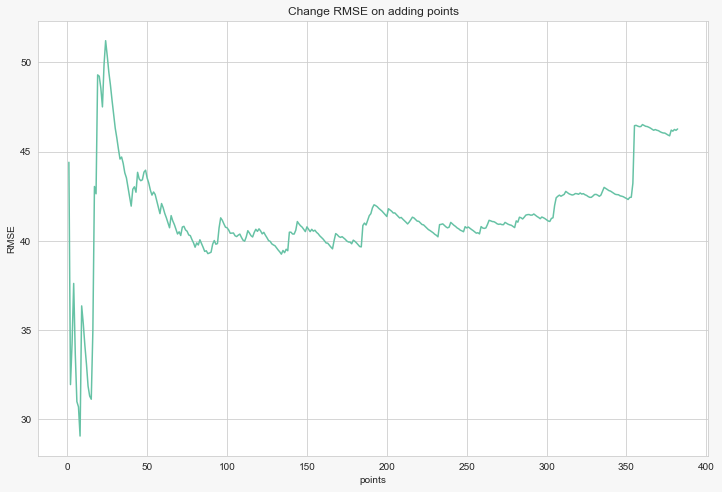

In [112]:
t = pd.DataFrame(data={'ds': y.index, 'y': y.values})

valid_forecast = []
for i in notebook.tqdm(range(valid_start, test_start)):

    # used like
    model_fit = Prophet(seasonality_mode = 'multiplicative').fit(t.iloc[:i,:])
    future = model_fit.make_future_dataframe(periods=1, freq='h')
    # make prediction
    prediction = model_fit.predict(future)
    valid_forecast.append([t.iloc[i,1], prediction.iloc[i,1], prediction.loc[i,'yhat_lower'], prediction.loc[i,'yhat_upper']])

t = pd.DataFrame(valid_forecast, columns=['y', 'y_hat', 'yhat_lower', 'yhat_upper'])

plot_cum_rmse(pd.DataFrame(valid_forecast))

The following results were obtained during validation:



model | n_iter | time | RMSE | MAE | MeanError
:- | :-: | :-: | :-: | :-: | :-: 
LinearRegression | 383 | 00:00:01 | 31.214 | 21.902 | -0.119	
LGBM | 383 | 00:00:10 | 30.704 | 21.058 | 1.966	
SARIMAX | 383 | 00:42:36 | 29.937 | 21.259 | 3.140	
Holt-Winters (M+M) | 383 | 00:05:17 | 27.872 | 18.735 | 3.426	
**Holt-Winters (box+A+A)** | 383 | 00:05:17 | 27.865 | 18.817 | 1.972	
STLForecast (ARIMA) | 383 | 00:10:28 | 30.755 | 21.491 | 0.132	
STLForecast (ES) | 383 | 00:09:52 | 28.233 | 19.627 | 0.323	
STLForecast (box+ES) | 383 | 00:10:16 | 28.263 | 19.468 | 1.695	
Facebook Prophet | 383 | 00:06:44 | 46.353 | 34.664 | 0.925	


`Holt-Winters (box+A+A)` and `STLForecast (ES)` performed well during validation, they have an unbiased forecast (low Mean Error), low RMSE, acceptable time

SARIMAX also showed good results, but its long running time, demanding memory resources and a larger forecast bias forces us to prefer a faster model of the same quality.

For the test, select `Holt-Winters (box+A+A)` it is better than all other RMSE models, fast validation run time (5 min), unbiased error

Facebook Prophet disappointed me.


## Testing

Holt-Winters won the validation with forecasting through additive trend and seasonality and with boxCox transformation.

We run a run of the model on the test. We forecast as before 1 step ahead

  0%|          | 0/425 [00:00<?, ?it/s]

RMSE: 32.152668064233985
MAE: 22.86654166421405
MeanError: 3.240840117324179


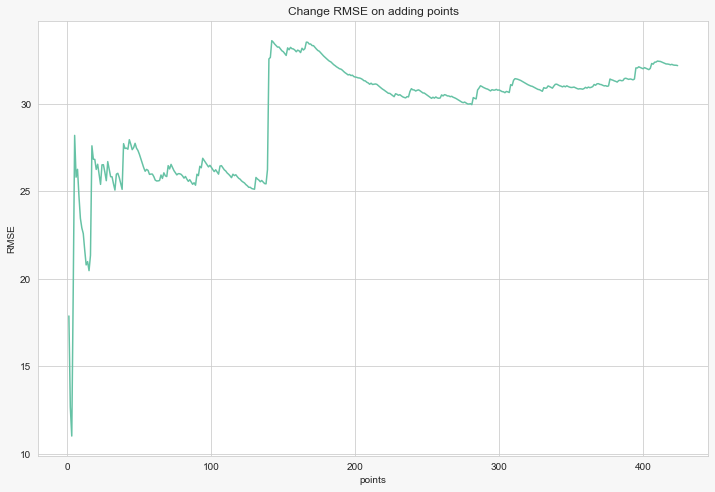

In [113]:
test_forecast = []
for i in notebook.tqdm(range(test_start, N)):
    # fit model
    model_fit = ExponentialSmoothing(
        endog=y.iloc[:i]+1,
        trend='add',
        seasonal = 'add',
        seasonal_periods=PERIOD,
        use_boxcox=True,
    ).fit()
    
    # make prediction
    prediction = model_fit.predict(i, i)
    test_forecast.append([y.iloc[i], prediction[0]])
plot_cum_rmse(pd.DataFrame(test_forecast))

According to the cumulative RMSE graph, it can be seen that the RMSE increased abruptly after 4 observations, these are emissions that raised the RMSE by about 8 units. It's bad that the test turned out to be outliers and the RMSE on the test is not comparable to the RMSE on validation. In any case, the fact that the RMSE turned out to be significantly higher on the test is not the result of retraining, but the impact of outliers and the consequence of an inadequate test sample

Let's plot the forecast and actual data on the test

<AxesSubplot:>

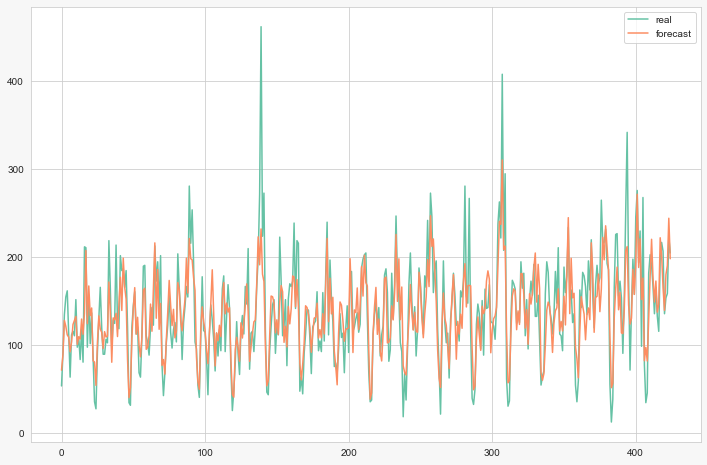

In [114]:
rdf = pd.DataFrame(test_forecast, columns=['real', 'forecast'])
rdf.plot()

Draw in the last week

<AxesSubplot:>

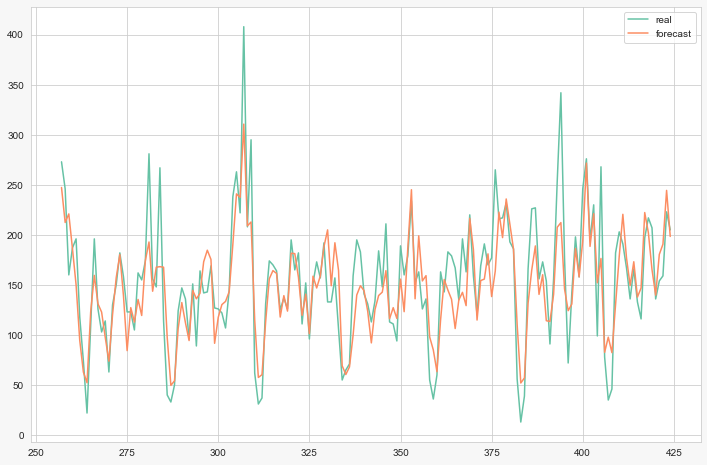

In [115]:
rdf[-24*7:].plot()

The main misses are peak spikes. We will not guess them in any way, these data are not in history, we just need to put up with these mistakes. Basically, the model guesses both the seasonality and the average level well.

## CONCLUSION

After downloading the data, we found out that they are complete, there is one interval per hour with a zero value
We conducted ADF and KPSS tests, which gave opposite results regarding the stationarity of the series near the trend. We constructed a series spread using the fast Fourier transform (FFT), highlighting the main cycle of 24h.

Several models were built that predict 1 step (hour) ahead: LinearRegression/LGBM with features, SARIMAX, Holt-Winters, STLForecast, Facebook Prophet

Holt-Winters with prediction through additive trend and seasonality and with boxCox transformation turned out to be the best on RMSE validation.

On the test, the best model showed RMSE 34 (baseline RMSE 48)

## Recommendations
* Remove outliers from the test, there may be external reasons that gave 4 significant peaks
* try stacking models
* try sequentially applying models (ES and then ARIMA to the residuals)
* Try neural models